![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/15.German_Legal_Model.ipynb)

## Colab Setup

In [ ]:
import json

with open('workshop_license_keys_365.json') as f_in:
    license_keys = json.load(f_in)

license_keys.keys()

dict_keys(['PUBLIC_VERSION', 'JSL_VERSION', 'SECRET', 'SPARK_NLP_LICENSE', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'SPARK_OCR_LICENSE', 'SPARK_OCR_SECRET'])

In [ ]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

secret = license_keys['SECRET']

os.environ['SPARK_NLP_LICENSE'] = license_keys['SPARK_NLP_LICENSE']
os.environ['AWS_ACCESS_KEY_ID']= license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']
version = license_keys['PUBLIC_VERSION']
jsl_version = license_keys['JSL_VERSION']

! pip install --ignore-installed -q pyspark==2.4.4

! python -m pip install --upgrade spark-nlp-jsl==$jsl_version  --extra-index-url https://pypi.johnsnowlabs.com/$secret

! pip install --ignore-installed -q spark-nlp==$version

import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from pyspark.sql.types import StructType, StructField, StringType
import itertools

spark = sparknlp_jsl.start(secret)

## Legal NER

The dataset used to train this model is taken from Leitner, et.al (2019)

*Leitner, E., Rehm, G., and Moreno-Schneider, J. (2019). Fine-grained Named Entity Recognition in Legal Documents. In Maribel Acosta, et al., editors, Semantic Systems. The Power of AI and Knowledge Graphs. Proceedings of the 15th International Conference (SEMANTiCS2019), number 11702 in Lecture Notes in Computer Science, pages 272–287, Karlsruhe, Germany, 9. Springer. 10/11 September 2019.*

**Source of the annotated text:**

Court decisions from 2017 and 2018 were selected for the dataset, published online by the Federal Ministry of Justice and Consumer Protection. The documents originate from seven federal courts: Federal Labour Court (BAG), Federal Fiscal Court (BFH), Federal Court of Justice (BGH), Federal Patent Court (BPatG), Federal Social Court (BSG), Federal Constitutional Court (BVerfG) and Federal Administrative Court (BVerwG).

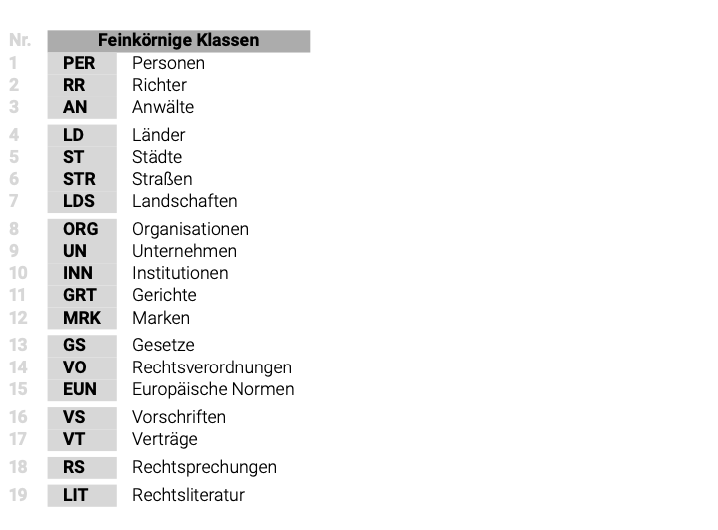

**Macro-average	 prec: 0.9210195, rec: 0.91861916, f1: 0.91981775**

**Micro-average	 prec: 0.9833763, rec: 0.9837547, f1: 0.9835655**

In [ ]:

documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line

sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")\

# Tokenizer splits words in a relevant format for NLP

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("w2v_cc_300d",'de','clinical/models')\
  .setInputCols(["sentence", 'token'])\
  .setOutputCol("embeddings")\
  .setCaseSensitive(False)

legal_ner = NerDLModel.pretrained("ner_legal",'de','clinical/models') \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

legal_ner_converter = NerConverterInternal() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")\


legal_pred_pipeline = Pipeline(
      stages = [
      documentAssembler,
      sentenceDetector,
      tokenizer,
      word_embeddings,
      legal_ner,
      legal_ner_converter
      ])

empty_df = spark.createDataFrame([['']]).toDF("text")

legal_pred_model = legal_pred_pipeline.fit(empty_df)

legal_light_model = LightPipeline(legal_pred_model)

w2v_cc_300d download started this may take some time.
Approximate size to download 1.2 GB
[OK!]
ner_legal download started this may take some time.
Approximate size to download 14.2 MB
[OK!]


In [ ]:
import pandas as pd

def get_ner_df (light_model, text):

  light_result = light_model.fullAnnotate(text)

  chunks = []
  entities = []

  for n in light_result[0]['ner_chunk']:
          
      chunks.append(n.result)
      entities.append(n.metadata['entity']) 


  df = pd.DataFrame({'chunks':chunks, 'entities':entities})

  return df


In [ ]:
text = '''
Jedoch wird der Verkehr darin naheliegend den Namen eines der bekanntesten Flüsse Deutschlands erkennen, welcher als Seitenfluss des Rheins durch Oberfranken, Unterfranken und Südhessen fließt und bei Mainz in den Rhein mündet.
Klein , in : Maunz / Schmidt-Bleibtreu / Klein / Bethge , BVerfGG , § 19 Rn. 9
Richtlinien zur Bewertung des Grundvermögens – BewRGr – vom19. I September 1966 (BStBl I, S.890) 
 '''
df = get_ner_df (legal_light_model, text)

df

chunks entities
0                                       Deutschlands       LD
1                                             Rheins      LDS
2                                        Oberfranken      LDS
3                                       Unterfranken      LDS
4                                          Südhessen      LDS
5                                              Mainz       ST
6                                              Rhein      LDS
7  Klein , in : Maunz / Schmidt-Bleibtreu / Klein...      LIT
8  Richtlinien zur Bewertung des Grundvermögens –...       VS
9                  I September 1966 (BStBl I, S.890)       VS

## German Public NER

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

public_pipeline = PretrainedPipeline('entity_recognizer_lg','de')


In [ ]:
text = """William Henry Gates III (* 28. Oktober 1955 in London) ist ein US-amerikanischer Geschäftsmann, Softwareentwickler, Investor und Philanthrop. Er ist bekannt als Mitbegründer der Microsoft Corporation. Während seiner Karriere bei Microsoft war Gates Vorsitzender, Chief Executive Officer (CEO), Präsident und Chief Software Architect und bis Mai 2014 der größte Einzelaktionär. Er ist einer der bekanntesten Unternehmer und Pioniere der Mikrocomputer-Revolution der 1970er und 1980er Jahre. Gates wurde in Seattle, Washington, geboren und wuchs dort auf. 1975 gründete er Microsoft zusammen mit seinem Freund aus Kindertagen, Paul Allen, in Albuquerque, New Mexico. Es entwickelte sich zum weltweit größten Unternehmen für Personal-Computer-Software. Gates leitete das Unternehmen als Chairman und CEO, bis er im Januar 2000 als CEO zurücktrat. Er blieb jedoch Chairman und wurde Chief Software Architect. In den späten neunziger Jahren wurde Gates für seine Geschäftstaktiken kritisiert, die als wettbewerbswidrig angesehen wurden. Diese Meinung wurde durch zahlreiche Gerichtsurteile bestätigt. Im Juni 2006 gab Gates bekannt, dass er eine Teilzeitstelle bei Microsoft und eine Vollzeitstelle bei der Bill & Melinda Gates Foundation, der privaten gemeinnützigen Stiftung, die er und seine Frau Melinda Gates im Jahr 2000 gegründet haben, übernehmen wird. [ 9] Er übertrug seine Aufgaben nach und nach auf Ray Ozzie und Craig Mundie. Im Februar 2014 trat er als Vorsitzender von Microsoft zurück und übernahm eine neue Position als Technologieberater, um den neu ernannten CEO Satya Nadella zu unterstützen.
Die Mona Lisa ist ein Ölgemälde aus dem 16. Jahrhundert, das von Leonardo geschaffen wurde. Es findet im Louvre in Paris statt."""

result = public_pipeline.fullAnnotate(text)[0]

chunks=[]
entities=[]
status=[]

for n in result['entities']:
    
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
        
df = pd.DataFrame({'chunks':chunks, 'entities':entities})

df

chunks entities
0           William Henry Gates III      PER
1                            London      LOC
2             Microsoft Corporation      ORG
3                         Microsoft      ORG
4                Gates Vorsitzender      ORG
5          Mikrocomputer-Revolution     MISC
6                             Gates      PER
7                           Seattle      LOC
8                        Washington      LOC
9                         Microsoft      ORG
10                      Kindertagen      LOC
11                       Paul Allen      PER
12                      Albuquerque      LOC
13                       New Mexico      LOC
14       Personal-Computer-Software      ORG
15                            Gates      PER
16         Chief Software Architect      ORG
17                            Gates      PER
18                  Gerichtsurteile     MISC
19                            Gates      PER
20                        Microsoft      ORG
21  Bill & Melinda Gates Foundation     MISC
22                    Melinda Gates      PER
23                        Jahr 2000     MISC
24                        Ray Ozzie      PER
25                     Craig Mundie      PER
26                        Microsoft      ORG
27                CEO Satya Nadella      ORG
28                        Mona Lisa     MISC
29                         Leonardo      PER
30                           Louvre      LOC
31                            Paris      LOC

## Highlight Entities

In [ ]:
import random
from IPython.core.display import display, HTML


def get_color():
    r = lambda: random.randint(100,255)
    return '#%02X%02X%02X' % (r(),r(),r())

from spacy import displacy

def display_entities(annotated_text, filter_labels=True):

    label_list = []
    sent_dict_list = []
    
    for n in annotated_text['ner_chunk']:

        ent = {'start': n.begin, 'end':n.end+1, 'label':n.metadata['entity'].upper()}
        
        label_list.append(n.metadata['entity'].upper())

        sent_dict_list.append(ent)
   
    document_text = [{'text':annotated_text['document'][0].result, 'ents':sent_dict_list,'title':None}]

    label_list = list(set(label_list))
                
    label_color={}
    
    for l in label_list:
        
        label_color[l]=get_color()
    
    colors = {k:label_color[k] for k in label_list}
        
    
    html_text = displacy.render(document_text, style='ent', jupyter=True, manual=True, options= {"ents": label_list, 'colors': colors})

    return html_text

In [ ]:
text = '''
Jedoch wird der Verkehr darin naheliegend den Namen eines der bekanntesten Flüsse Deutschlands erkennen, welcher als Seitenfluss des Rheins durch Oberfranken, Unterfranken und Südhessen fließt und bei Mainz in den Rhein mündet.
Klein , in : Maunz / Schmidt-Bleibtreu / Klein / Bethge , BVerfGG , § 19 Rn. 9
Richtlinien zur Bewertung des Grundvermögens – BewRGr – vom19. I September 1966 (BStBl I, S.890) 
 '''

ann_text = legal_light_model.fullAnnotate(text)

display_entities (ann_text[0])